In [194]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

In [195]:
f = h5py.File('/Users/ahyeon/Desktop/activ misc/predict_scores2.h5', 'r')

In [196]:
predictions = f['score'][:]
norm_predictions = f['norm_score'][:]
labels = f['clusters'][:]
umap_dims = f['umap_dimensions'][:]
cluster_sizes = f['cluster_sizes'][:]

In [197]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

In [198]:
def accuracy(mat):
    return mat.trace()/mat.sum()

def specificity(tn, fp):
    return tn/(tn+fp)

def sensitivity(tp, fn):
    return tp/(tp+fn)

def fscore(tp, fp, fn):
    return (2*tp)/(2*tp+fp+fn)

In [199]:
def ind_statistics(matrix):
    mat = np.matrix(matrix)
    allvals=[]
    tps = []
    tns = []
    fps = []
    fns = []
    for i in range(mat.shape[0]):
        tp = mat[i,i]
        tn = mat.sum() - mat[i,:].sum() - mat[:,i].sum() + mat[i,i]
        fp = mat[:,i].sum() - mat[i,i]
        fn = mat[i,:].sum() - mat[i,i]
        tps.append(tp)
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
    allvals.append(tps)
    allvals.append(tns)
    allvals.append(fps)
    allvals.append(fns)
    return allvals

In [200]:
def find_avg_spec(array):
    allspec = []
    for i in range(len(array[0])):
        vals = []
        for elem in array:
            vals.append(elem[i])
        tp = vals[0]
        tn = vals[1]
        fp = vals[2]
        fn = vals[3]

        spec = specificity(tn, fp)
        allspec.append(spec)
    allspec_mean = np.mean(allspec)
    return(allspec_mean)

In [201]:
def find_avg_sens(array):
    allsens = []
    for i in range(len(array[0])):
        vals = []
        for elem in array:
            vals.append(elem[i])
        tp = vals[0]
        tn = vals[1]
        fp = vals[2]
        fn = vals[3]

        sens = sensitivity(tp, fn)
        allsens.append(sens)
    allsens_mean = np.mean(allsens)
    return(allsens_mean)

In [202]:
def find_avg_fscore(array):
    allf = []
    for i in range(len(array[0])):
        vals = []
        for elem in array:
            vals.append(elem[i])
        tp = vals[0]
        tn = vals[1]
        fp = vals[2]
        fn = vals[3]

        f = fscore(tp, fp, fn)
        allf.append(f)
    allf_mean = np.mean(allf)
    return(allf_mean)


In [144]:
x = [[70.0, 72.0], [72.0, 70.0], [53.0, 52.0], [52.0, 53.0]]
find_avg_fscore(x)

0.57487091222030973

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


[[ 1.17355372  1.13888889  1.40350877 ...,  5.33333333  2.33333333  2.        ]
 [ 1.15267176  1.12037037  1.09876543 ...,  1.16666667  1.16666667
   1.11111111]
 [ 1.30172414  1.05172414  1.15714286 ...,  2.16666667  1.33333333  2.25      ]
 ..., 
 [ 1.01351351  1.12264151  1.01149425 ...,  2.66666667  1.85714286  3.75      ]
 [ 1.27826087  1.22857143  1.35       ...,  2.25        1.          5.        ]
 [ 1.06716418  1.13761468  1.47457627 ...,  8.          4.25        2.16666667]]


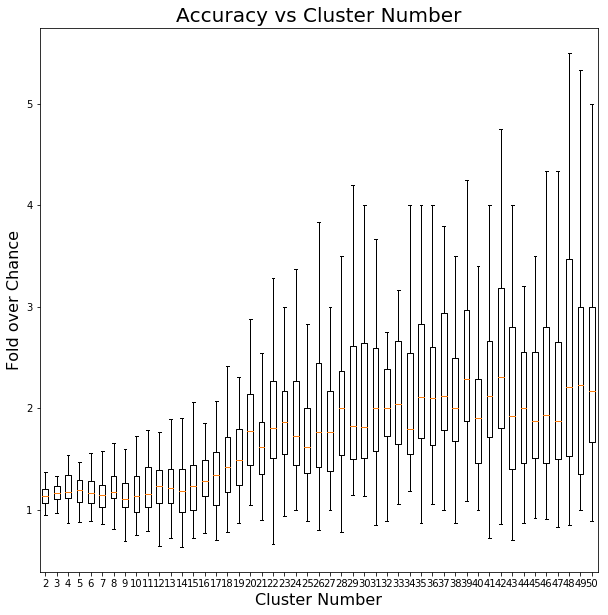

In [203]:
# accuracy
fold_over_chance = np.zeros((len(cluster_sizes), 50))

for ii,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [x/y for x, y in zip(acc, norm_acc)]
    fold_over_chance[ii,:] = foc

plt.figure(figsize=(10,10))
print(fold_over_chance.T)
plt.boxplot(fold_over_chance.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Accuracy vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/acc_vs_clusters_predictions.pdf')

In [204]:
# avg sensitivity

sens_arr = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    sens_50 = []
    norm_sens_50 = []
    for i in range(50):
        x = ind_statistics(all50mat[i])
        y = ind_statistics(norm_all50mat[i])
        sens = find_avg_sens(x)
        norm_sens = find_avg_sens(y)
        sens_50.append(sens)
        norm_sens_50.append(norm_sens)
    foc = [j/k for j,k in zip(sens_50, norm_sens_50)]
    sens_arr[ii,:] = foc
    

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


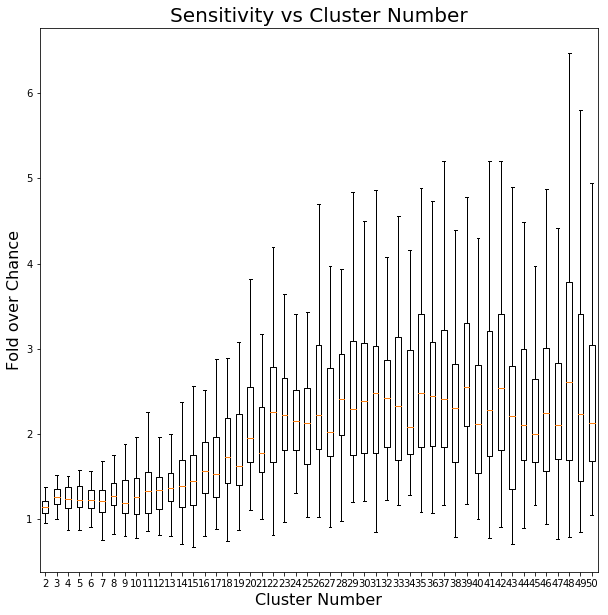

In [205]:
plt.figure(figsize=(10,10))
plt.boxplot(sens_arr.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Sensitivity vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/sens_vs_clusters_predictions.pdf')

In [206]:
# avg fscore

f_arr = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    f_50 = []
    norm_f_50 = []
    for i in range(50):
        x = ind_statistics(all50mat[i])
        y = ind_statistics(norm_all50mat[i])
        f = find_avg_fscore(x)
        norm_f = find_avg_fscore(y)
        f_50.append(f)
        norm_f_50.append(norm_f)
    foc = [j/k for j,k in zip(f_50, norm_f_50)]
    f_arr[ii,:] = foc

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


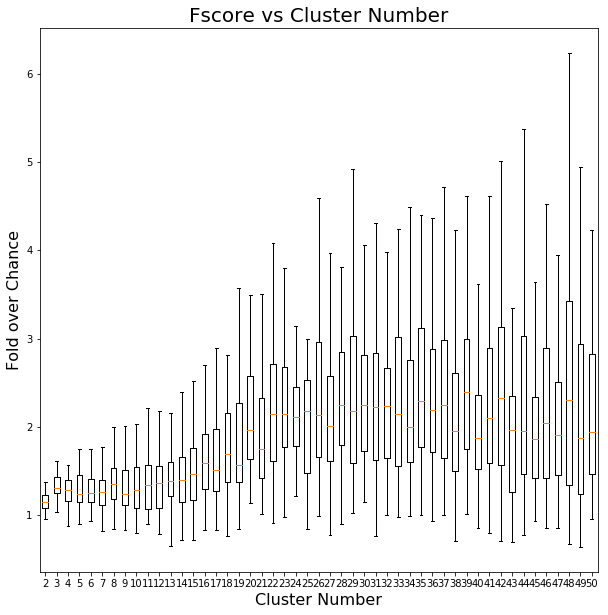

In [207]:
plt.figure(figsize=(10,10))
plt.boxplot(f_arr.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Fscore vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/fscore_vs_clusters_predictions.pdf')

In [208]:
# avg specificity

spec_arr = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    spec_50 = []
    norm_spec_50 = []
    for i in range(50):
        x = ind_statistics(all50mat[i])
        y = ind_statistics(norm_all50mat[i])
        spec = find_avg_spec(x)
        norm_spec = find_avg_spec(y)
        spec_50.append(spec)
#         norm_spec_50.append(norm_spec)
#     foc = [j/k for j,k in zip(spec_50, norm_spec_50)]
    spec_arr[ii,:] = spec_50

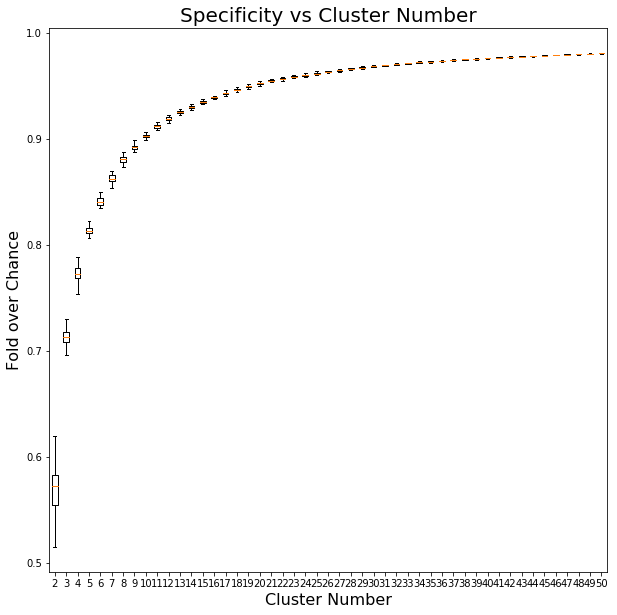

In [209]:
plt.figure(figsize=(10,10))
plt.boxplot(spec_arr.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Specificity vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/spec_vs_clusters_predictions.pdf')

In [151]:
for ii, c in enumerate(cluster_sizes[:2]):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    f_50 = []
    norm_f_50 = []
    
    row_sum = all50mat[0].sum(axis=0)
    col_sum = all50mat[0].sum(axis=1)
    print(row_sum, col_sum)

[ 123.  124.] [ 122.  125.]
[  69.  151.   27.] [  75.  125.   47.]


In [210]:
acc = fold_over_chance.mean(axis=1)
sens = sens_arr.mean(axis=1)
fscore = f_arr.mean(axis=1)

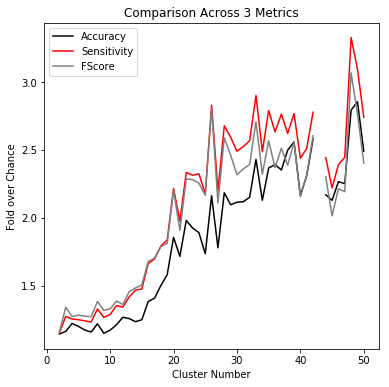

In [211]:
plt.figure(figsize=(6,6))
plt.plot(cluster_sizes, acc, color='black', label='Accuracy')
plt.plot(cluster_sizes, sens, color='red', label='Sensitivity')
plt.plot(cluster_sizes, fscore, color='grey', label='FScore')
plt.legend()
plt.xlabel('Cluster Number')
plt.ylabel('Fold over Chance')
plt.title('Comparison Across 3 Metrics')
plt.savefig('/Users/ahyeon/Desktop/activ misc/acc_comparison_plot.pdf')